I wish to perform EMC with many classses with no rotations modeled. Is there any point to this? Yes especially if there is background, this can be done with many types of data and should be much faster. 

$$
\begin{align}
K_{di} &= \text{photon counts for frame $d$ at pixel $i$} \\
W_{ti} &= \text{class $t$ at pixel $i$} \\ 
B_{li} &= \text{background model $l$ at pixel $i$} \\
w_{d} &= \text{fluence for sample at frame $d$} \\
b_{dl} &= \text{fluence for background l at frame $d$} \\
\end{align}
$$

Log-likelihood:
$$
\begin{align}
\log{\mathcal{L}}(K|WBwb) &= \sum_d \log\left[\sum_t \prod_i R(WBwb | K) \right] 
\end{align}
$$

R is the likelihood that a given frame is a poisson sampling of model W (weighted by fluence for that frame w) plus background terms B (weighted by b)
$$
\begin{align}
R(WBwb | K)_{dti} &= \frac{ T_{dti}^{K_{di}} e^{-T_{dti}} }{ K_{di}! } \\
T_{dti} &= w_{d} W_{ti} + \sum_{l=0}^L b_{d, l} B_{li}
\end{align}
$$

Probability:
$$
\begin{align}
P_{dt} &\equiv \frac{R_{dt}}{R_d} = \frac{\prod_{i} R_{dti}}{\sum_t \prod_i R_{dti}}
\end{align}
$$

Gradients:
$$
\begin{align}
\frac{\partial LL}{\partial W_{ti}} &= \sum_d P_{dt} w_d \left(\frac{K_{di}}{T_{dti}} -1  \right)
\end{align}
$$

$$
\begin{align}
\frac{\partial LL}{\partial B_{li}} &= \sum_t \sum_d P_{dt} b_{dl} \left(\frac{K_{di}}{T_{dti}} - 1 \right)
\end{align}
$$

$$
\begin{align}
\frac{\partial LL}{\partial w_d} &= \sum_t  P_{dt} \sum_i W_{ti} \left(\frac{K_{di}}{T_{dti}} - 1 \right)
\end{align}
$$

$$
\begin{align}
\frac{\partial LL}{\partial b_{dl}} &= \sum_t  P_{dt} \sum_i B_{li} \left(\frac{K_{di}}{T_{dti}} - 1 \right)
\end{align}
$$

The expectation maximisation can be done per pixel for W and B, and per pattern for w and b. This suggests an alternating approach: maximise expectation for W and B per pixel (many loops), then maximise for w and b per image (many loops), then loop that. Calculating the probability matrix can be parallelised over d or i. 

So, we need the hessian for W and B and the hessian for w and b.

This raises the question: will W and B look like a total mess? Since the optimisation at each pixel doesn't care about it's neighbour. Actually I think P will fix that. 

Hessians:
$$
\begin{align}
\frac{\partial^2 LL}{\partial W_{ti}\partial W_{t'i'}} &= - \delta_{tt'ii'} \sum_d w_d^2 P_{dt}  \frac{K_{di}}{T^2_{dti}}
\end{align}
$$

$$
\begin{align}
\frac{\partial^2 LL}{\partial B_{li}\partial B_{l'i'}} &= - \delta_{ii'} \sum_t \sum_d b_{dl}b_{dl'} P_{dt}  \frac{K_{di}}{T^2_{dti}}
\end{align}
$$

$$
\begin{align}
\frac{\partial^2 LL}{\partial W_{ti}\partial B_{li'}} &= - \delta_{ii'} \sum_d w_d b_{dl} P_{dt}  \frac{K_{di}}{T^2_{dti}}
\end{align}
$$

So, the curvature along a search direction can be calculated as follows:
$$
\begin{align}
g_{tli} &= \left( g^W_{ti}, g^B_{li} \right) \qquad \text{search direction for W and B}
\end{align}
$$

$$
\begin{align}
c &= 
\begin{bmatrix} 
g^W_{ti} & g^B_{li}
\end{bmatrix}
\cdot 
\begin{bmatrix} 
H_{WW} & H_{WB} \\
H_{BW} & H_{BB}
\end{bmatrix}
\cdot 
\begin{bmatrix} 
g^W_{ti} \\
g^B_{li}
\end{bmatrix}
\end{align}
$$

Where the dot product is over $l$ and $t$

$$
\begin{align}
c_i = -&\sum_t (g^W_{ti})^2 \sum_d w_d^2 P_{dt} \frac{K_{di}}{T_{dti}^2} \\
      -&\sum_t \sum_d \left( \sum_l b_{dl} g^B_{li} \right)^2 P_{dt} \frac{K_{di}}{T_{dti}^2} \\
      -2&\sum_t g^W_{ti} \sum_d w_d \left( \sum_l b_{dl} g^B_{li} \right) P_{dt} \frac{K_{di}}{T_{dti}^2}
\end{align}
$$

$$
\begin{align}
c_i = -&\sum_t \sum_d \left[ w_d g^W_{ti}  + \sum_l b_{dl} g^B_{li}\right]^2 P_{dt} \frac{K_{di}}{T_{dti}^2} 
\end{align}
$$

The curvature for the fluence terms are:
$$
\begin{align}
c_d = -&\sum_t \sum_i \left[ W_{ti} g^w_d  + \sum_l B_{dl} g^b_{dl}\right]^2 P_{dt} \frac{K_{di}}{T_{dti}^2} 
\end{align}
$$

The curvature is zero or positive if and only if $K_{di} = 0$ for all images at a given pixel ($c_i$), or if and only if $K_{di} = 0$ for all pixels ($c_d$).

# Numerical calculation of P

Use logarithms to multiply many small numbers together.

divide by maximum value to sum numbers that vary by magnitude 

$$
\begin{align}
P_{dt} &\equiv \frac{R_{dt}}{R_d} = \frac{\prod_{i} R_{dti}}{\sum_t \prod_i R_{dti}} \\
       &= \frac{\prod_i T^K e^-T}{K!} \left( \sum_t \frac{\prod_i T^K e^-T}{K!} \right)^{-1} \\
       &= \prod_i T^K e^-T \left( \sum_t \prod_i T^K e^-T \right)^{-1} \\
\end{align}
$$

$$
\begin{align}
       \prod_i T^K e^-T &= \exp\left[ \sum_i K \log{T} - T \right] = \exp\left[ \sum_i K \log{T}\right] \exp\left[-\sum_i  T \right]
\end{align}
$$

Each subproblem has the form:
$$
\begin{align}
f(x) &= \sum_i \frac{a_i}{x + b_i} = c
\end{align}
$$
Which is a monotonically decreasing function, with a maximum value of $\sum_i a_i / b_i$ at $x=0$ and a minimum value of $0$ as $x\rightarrow \infty$. The gradient of $f$ monotonically *increases* in value and *decreases* in magnitude. Note that the maximum value will $\infty$ if any of the $b_i$ terms are zero. 

An upper bound of the solution $x_\text{max}$ can be found by setting $b_i = 0$, since increasing any $b_i$ value will certianly decrease $f$ and shift the zero point the left of the true solution: 
$$
\begin{align}
f(x; b_i = 0) &= \sum_i \frac{a_i}{x_\text{max}} = c\\
x_\text{max} &= \frac{1}{c} \sum_i a_i
\end{align}
$$

So, on the interval between $[0, x_\text{max}]$, $f$ will decrease from the maximum $\sum_i a_i / b_i$ at $x=0$, to the minimum $f(b) = \sum_i a_i / (\sum_j a_j / c + b_i)$ at $x = x_\text{max}$. We can rescale $x$ over this interval between 0 and 1 and $f$ to 1 at the midpoint (since it might not be safe to evaluate $f(0)$ if any $b_i =0$):
$$
\begin{align}
g(x) &\equiv f(x_\text{max}/2)^{-1} f(x) = s f(x)\\
%
y &\equiv x / (\sum_j a_j / c) = x / x_\text{max}
\end{align}
$$

$$
\begin{align}
h(y) &\equiv g(x_\text{max} y) = s \sum_i \frac{a_i}{b y + b_i}
\end{align}
$$

We could go further and define:
$$
\begin{align}
f(x; a', b') &= s f(x_\text{max} x, a, b) = \sum_i \frac{a'_i}{x + b'_i} \\
\text{where } a'_i &= s a_i / x_\text{max}
\text{ and } b'_i =  b_i / x_\text{max}
\end{align}
$$

The true solution will be found when:
$$
\begin{align}
x &= x_\text{max} \underset{y}{\operatorname{argmin}} | f(y; a', b') - s c |
\end{align}
$$


So there are two vectors that define the shape of the function between 0 and 1 ($a'$ and $b'$).

Solution strategy:
- Set minval for x ($x_\text{min}$)
    - don't know how else to do this yet
- Set relative tolerance (tol) convergence criteria
    - how do I know if this is below numerical precision?

1. If $I = 0$ return the original value for $x$
2. If $c \le 0$ return $x$ and a warning (the true solution is $x \rightarrow \infty$)
3. Calculate $x_\text{max} = \frac{1}{c} \sum_i a_i$ 
4. if $x_\text{max} = 0$ return x 
    1. this implies that all a[i] = 0, in which case there is no solution.
4. If $b'_i = 0$ for all $i$ then return $x_\text{max}$
    1. The true solution is now guaranteed to be $< x_\text{max}$
5. If $c > f(x_\text{min})$ then return $x_\text{min}$ (background dominated) 
6. calculate scale factor $s = f(x_\text{max} / 2)$ 
7. caclculate $a'$ and $b'$ 
8. find root of $f(x, a', b') = s c$
    1. stop when step-size / x < tol


a-vector: [2.7454564e-05]
b-vector: [0.02886089]
c-value : 0.3600068
all b-values > 0, setting minval to 0
c > fmax, setting x to minval 0.0


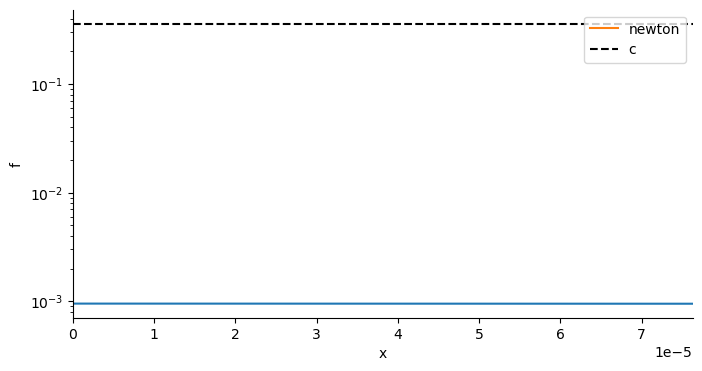

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import utils
%matplotlib inline

np.random.seed(1)
#I = 100000
#a = 1 * np.random.random(I)
#b = 10 * np.random.random(I)
#c = 20000

a = np.array([2.7454564e-05,])
b = np.array([0.02886089,])
c = 0.3600068

# calculate xmax
xmax = 1/c * np.sum(a)

x0 = 0.99 * xmax

x, iters, xs = utils.find_root_f(x0, a.copy(), b.copy(), c, 
                           minval = 1e-5, 
                           tol = 1e-6, 
                           method = "model", 
                           maxiters = 100, 
                           return_points = True, 
                           v = True)
t = np.empty_like(b)

xs = xmax * np.clip(np.array(xs), 0, 1)
fs = [utils.calc_f(xs[i], a, b, t) for i in range(xs.shape[0])]

# plot result
y  = np.linspace(0, xmax, 100)
fy = [utils.calc_f(y[i], a, b, t) for i in range(y.shape[0])]


fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
ax.plot(y, fy)
ax.plot(xs, fs, label= 'newton')
ax.hlines(c, 0, xmax, colors='k', linestyles='--', label='c')
ax.scatter(xs, fs, s=10)
ax.set_yscale('log')
#ax.set_ylim([0, 3])
ax.set_xlim([0, xmax])
ax.spines[['right', 'top']].set_visible(False)
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('f')
plt.show()

Newton's method has quadratic convergence near the solution but has the problem that it always undershoots when stepping to the right and overshoots when stepping to the left. Perhaps there is a way to moderate this behaviour using the curvature of $f$... 

On the other hand, bisection will be more stable but only provides linear convergence on the relative error. Since the gradient is also monotonically decreasing: the intersection of a straight line between a trial point and a boundary point with the gradient will always yield a point to the right of the true solution. We could update the bisection method with this information. 

In [234]:
!h5ls -r /home/andyofmelbourne/Documents/2023/P3004-take-2/gold/hits_r0087.cxi

/                        Group
/entry_1                 Group
/entry_1/cellId          Dataset {59087}
/entry_1/data_1          Group
/entry_1/data_1/data     Soft Link {/entry_1/instrument_1/detector_1/data}
/entry_1/experiment_identifier Dataset {59087}
/entry_1/instrument_1    Group
/entry_1/instrument_1/data_1 Group
/entry_1/instrument_1/detector_1 Group
/entry_1/instrument_1/detector_1/data Dataset {59087, 16, 128, 512}
/entry_1/instrument_1/detector_1/good_pixels Dataset {16, 128, 512}
/entry_1/instrument_1/name Dataset {SCALAR}
/entry_1/pulseId         Dataset {59087}
/entry_1/sample_1        Group
/entry_1/sample_1/name   Dataset {SCALAR}
/entry_1/trainId         Dataset {59087}


In [56]:
import static_emc_init
import config as c
import utils 
import pickle
import numpy as np
import pyqtgraph as pg
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%gui qt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# initialise recon
c.classes            = 100
c.background_classes = 1
c.max_frames         = 1000

c.beta  = 0.01
c.iters = 1

static_emc_init.init(c)

loading mask: /home/andyofmelbourne/Documents/2023/P3004-take-2/gold/badpixel_mask_r0096.h5
loading data: /home/andyofmelbourne/Documents/2023/P3004-take-2/gold/badpixel_mask_r0096.h5


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 636.14it/s]


loading transposed data: /home/andyofmelbourne/Documents/2023/P3004-take-2/gold/badpixel_mask_r0096.h5


100%|██████████████████████████████████████████████████████████████████████████████████████████| 15035/15035 [00:02<00:00, 5812.72it/s]


Found 1000 frames with 15035 unmasked pixels
saving reconstruction variables to: recon.pickle


In [2]:
# load state
r = pickle.load(open('recon.pickle', 'rb'))

evs = []

normalised? True
expectation_value: 0.00e+00


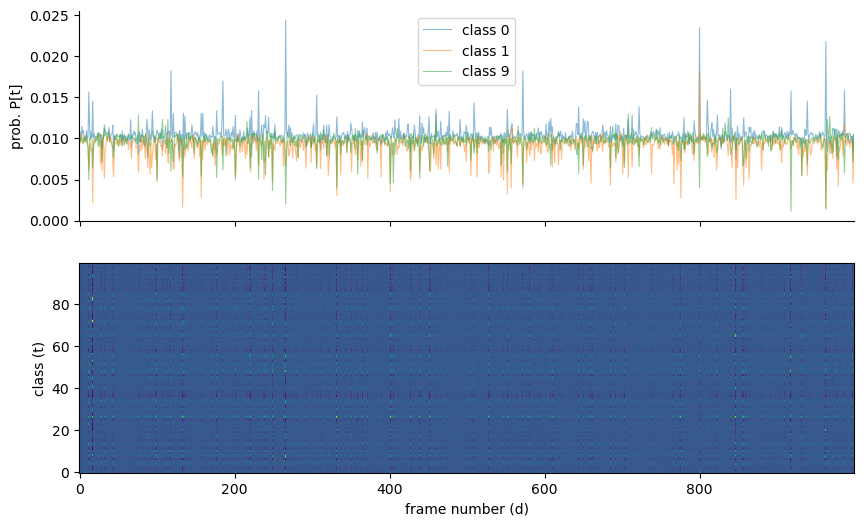

In [373]:
# calculate probability matrix
#r.beta = 0.1
#expectation_value = utils.calculate_P(r.K, r.inds, r.w, r.W, r.b, r.B, r.LR, r.P, r.PT, r.beta)
#evs.append(expectation_value)

r = pickle.load(open('recon.pickle', 'rb'))
expectation_value = 0.

# sum_t P[d, t] = 1
#print(np.sum(r.P, axis=1))
print('normalised?', np.allclose( np.sum(r.P, axis=1), 1))

# E = sum_ P[d, t] LR[d, t]
print('expectation_value: {:.2e}'.format(expectation_value))

fig, axs = plt.subplots(2, 1, sharex= True)
fig.set_size_inches(10, 6)
ax = axs[0]
t_s = [0,1,9] #np.random.randint(0, r.W.shape[0], 3)
for t in t_s :
    ax.plot(range(r.w.shape[0]), r.P[:, t], linewidth=0.8, alpha=.5, label=f'class {t}')
#ax.set_xlabel('frame number (d)')
ax.set_ylabel('prob. P[t]')
ax.legend()
ax.spines[['right', 'top']].set_visible(False)
    
ax = axs[1]
im = ax.imshow(r.P.T**0.5, aspect='auto', origin='lower', interpolation='nearest')
ax.set_xlabel('frame number (d)')
ax.set_ylabel('class (t)')

#plt.colorbar(mappable=im)

plt.show()
    


In [355]:
ksums = np.array([np.sum(k) for k in r.K])

pg.plot(ksums)
pg.plot(r.P[:, 0])

In [191]:
# show gradient
t = 1
g    = np.zeros_like(r.W[t])
xmax = np.zeros_like(r.W[t])

kd = np.zeros((r.I,), dtype=np.uint8)
for d in range(r.D):
    kd.fill(0)
    kd[r.inds[d]] = r.K[d]
    T  = r.w[d] * r.W[t]
    g += r.P[d, t] * r.w[d] * (kd / T - 1)
    xmax += r.P[d, t] * kd
    
xmax /= np.dot(r.w, r.P[:, t])
    
# make images
ims = np.zeros((3, 128, 128), dtype=float)
frame = np.zeros((16, 128, 512), dtype=float)

frame.ravel()[r.pixel_indices] = g
ims[0] = frame[0, :128, :128]

frame.ravel()[r.pixel_indices] = xmax
ims[1] = frame[0, :128, :128]

frame.ravel()[r.pixel_indices] = r.W[t]
ims[2] = frame[0, :128, :128]

pg.show(ims)

In [194]:
plot = pg.plot(r.P[:, 0])
plot.plot(r.P[:, 1], pen=pg.mkPen('r'))

In [195]:
print()

In [ ]:
# show K logT - T
d = 1 
t = 0

T = r.w[d] * r.W[t]

kd = np.zeros((r.I,), dtype=np.uint8)
kd[r.inds[d]] = r.K[d]

L = kd * np.log(T) - T

print(np.sum(L))


# make images
ims = np.zeros((3, 128, 128), dtype=float)
frame = np.zeros((16, 128, 512), dtype=float)

frame.ravel()[r.pixel_indices] = T
ims[0] = frame[0, :128, :128]

frame.ravel()[r.pixel_indices] = kd
ims[1] = frame[0, :128, :128]

frame.ravel()[r.pixel_indices] = L
ims[2] = frame[0, :128, :128]
    
pg.show(ims)

In [ ]:
plot = pg.plot(r.P)

In [179]:
print()

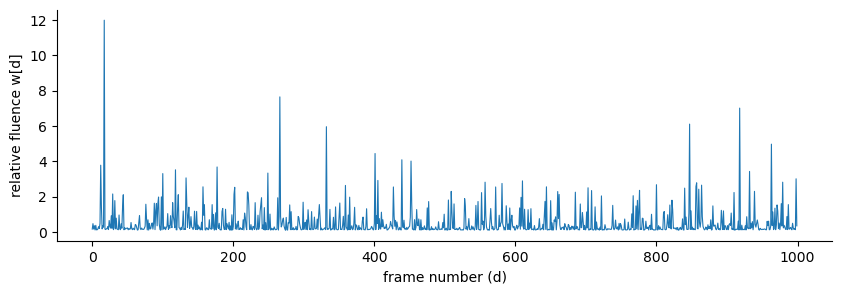

In [339]:
# update w
#utils.update_w(r.P, r.w, r.W, r.b, r.B, r.K, r.inds)
r = pickle.load(open('recon.pickle', 'rb'))

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 3)

ax.plot(range(r.w.shape[0]), r.w, linewidth=0.8, alpha=1.)
ax.set_xlabel('frame number (d)')
ax.set_ylabel('relative fluence w[d]')
ax.spines[['right', 'top']].set_visible(False)

plt.show()

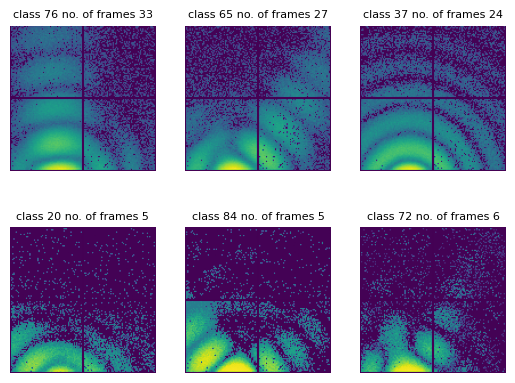

In [349]:
# update W
#utils.update_W(r.PT, r.w, r.W, r.b, r.B, r.KT, r.indsT)
r = pickle.load(open('recon.pickle', 'rb'))

# favour = sum_d PT[t, d]
favour = np.sum(r.P, axis=0)
ts = np.argsort(favour)
most  = ts[-3:][::-1]
least = ts[:3]

fav     = [favour[most], favour[least]]
labels  = [most, least]
classes = [r.W[most], r.W[least]]

image = np.empty((16, 128, 512), dtype=float)

# show 3 most favoured classes and 3 least favoured class
fig, axs = plt.subplots(2, 3)

for i in range(2):
    for j in range(3):
        image.fill(0)
        image.ravel()[r.pixel_indices] = classes[i][j]
        axs[i, j].imshow(image[0, :128, :128]**0.2, origin='lower')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'class {labels[i][j]} no. of frames {round(fav[i][j])}', fontsize=8)
plt.show()

In [351]:
ims = np.zeros((r.C, 128, 128), dtype=float)
frame = np.zeros((16, 128, 512), dtype=float)
for c in range(r.C):
    frame.ravel()[r.pixel_indices] = r.W[c]
    ims[c] = frame[0, :128, :128]
    
pg.show(ims[ts[::-1]]**0.5)
#pg.show(ims)

In [327]:
ts

array([59, 68, 97, 50, 48, 70, 26, 76, 31, 34, 75, 20, 67, 47, 52, 64, 39,
       19, 60, 10,  7, 85,  6, 13, 82,  5, 72, 94, 51, 40, 84, 98, 16, 36,
       43, 35, 58, 96, 24, 63, 78, 80, 91, 44, 90, 62, 61, 95, 66, 86, 69,
       92, 71, 73, 74, 89, 88, 81, 83, 93,  0, 49, 56,  1,  2,  4, 12, 14,
       15, 17, 18, 21, 22, 23, 25, 57, 28, 99, 29, 55, 30, 33, 41, 53, 38,
       54,  3,  9, 45, 87, 37, 77, 27, 11, 46, 32, 79, 42, 65,  8])

In [353]:
favour[ts[::-1]]

array([33.154346 , 27.4457   , 23.935076 , 21.539108 , 20.597496 ,
       16.586494 , 14.892163 , 13.811851 , 10.584468 , 10.007344 ,
        9.993806 ,  9.869304 ,  9.86767  ,  9.781584 ,  9.683555 ,
        9.668275 ,  9.554132 ,  9.5095825,  9.418246 ,  9.418053 ,
        9.417835 ,  9.400389 ,  9.39373  ,  9.391907 ,  9.34607  ,
        9.325442 ,  9.321196 ,  9.301146 ,  9.299979 ,  9.297385 ,
        9.296777 ,  9.293374 ,  9.290126 ,  9.2787   ,  9.276539 ,
        9.274772 ,  9.269319 ,  9.268261 ,  9.264908 ,  9.263097 ,
        9.260764 ,  9.259242 ,  9.257584 ,  9.254983 ,  9.251919 ,
        9.250137 ,  9.244886 ,  9.244598 ,  9.240616 ,  9.23391  ,
        9.228221 ,  9.216838 ,  9.20798  ,  9.206675 ,  9.204823 ,
        9.2007065,  9.198432 ,  9.195881 ,  9.191498 ,  9.191446 ,
        9.189534 ,  9.1868925,  9.185041 ,  9.181111 ,  9.175591 ,
        9.17381  ,  9.173452 ,  9.172731 ,  9.169749 ,  9.167616 ,
        9.167036 ,  9.160886 ,  9.1526165,  9.148507 ,  9.1478

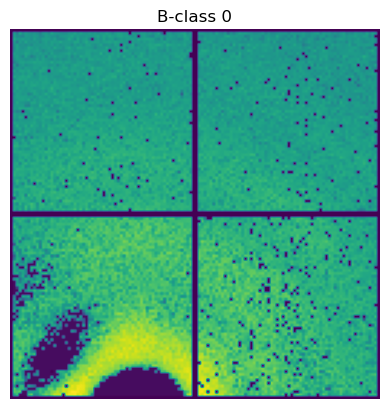

In [343]:
# update B
#utils.update_B(r.PT, r.w, r.W, r.b, r.B, r.KT, r.indsT)
r = pickle.load(open('recon.pickle', 'rb'))

# show up to 3 background models
bs = min(r.B.shape[0], 3)
fig, axs = plt.subplots(1, bs)
axs = np.array(axs).reshape(-1)

image = np.empty((16, 128, 512), dtype=float)

for i in range(bs):
    image.fill(0)
    image.ravel()[r.pixel_indices] = r.B[i]
    axs[i].imshow(image[0, :128, :128]**0.2, origin='lower')
    axs[i].axis('off')
    axs[i].set_title(f'B-class {i}')
plt.show()

In [242]:
r.B

array([[1.1294565e-10, 1.0000000e-10, 1.0000000e-10, ..., 1.0000000e-10,
        1.0000000e-10, 1.0000000e-10],
       [1.1294565e-10, 1.0000000e-10, 1.0000000e-10, ..., 1.0000000e-10,
        1.0000000e-10, 1.0000000e-10]], dtype=float32)

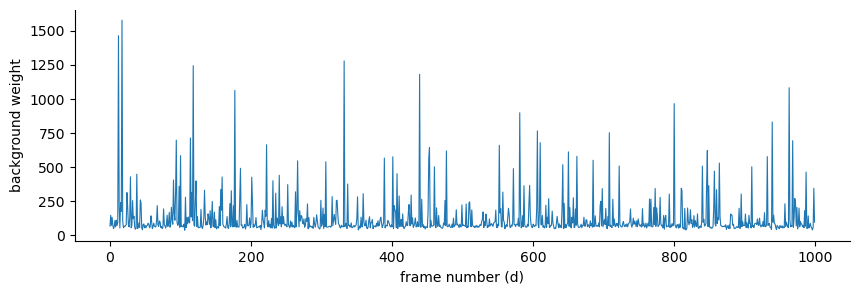

In [345]:
# update b
#utils.update_b(r.P, r.w, r.W, r.b, r.B, r.K, r.inds)
r = pickle.load(open('recon.pickle', 'rb'))

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 3)

for l in range(r.b.shape[1]):
    ax.plot(range(r.b.shape[0]), r.b[:, l], linewidth=0.8, alpha=1., label=f'b class {l}')
ax.set_xlabel('frame number (d)')
ax.set_ylabel('background weight')
ax.spines[['right', 'top']].set_visible(False)

plt.show()

In [71]:
np.sum(r.b, axis=0)

array([2469.587], dtype=float32)

In [72]:
r.b.shape

(1000, 1)

In [109]:
# save state
pickle.dump(r, open('recon.pickle', 'wb'))

In [148]:
np.sort(favour)

array([4.60593098e-13, 1.06763817e-12, 1.08054754e-12, 2.42802532e-11,
       4.23204041e-11, 9.81206574e-11, 1.51893387e-10, 3.85792925e-10,
       7.77751807e-10, 8.64137484e-10, 9.91801419e-10, 1.01655466e-08,
       1.97138110e-08, 3.92238974e-07, 4.11640940e-07, 6.74033174e-07,
       9.16454496e-07, 9.69567964e-07, 1.13095916e-06, 1.22286167e-06,
       3.84564191e-06, 4.36496384e-06, 5.45885450e-06, 1.15436142e-05,
       1.23206455e-05, 2.23358093e-05, 9.89359469e-05, 2.59068038e-04,
       3.69244692e-04, 4.54199064e-04, 7.63592951e-04, 8.99166043e-04,
       1.00080250e-03, 1.24488329e-03, 1.54447102e-03, 6.93603605e-03,
       7.79200047e-02, 8.31191689e-02, 3.02448124e-01, 5.73825419e-01,
       7.43487120e-01, 9.92248416e-01, 1.00004721e+00, 1.03015208e+00,
       1.03198075e+00, 1.17212331e+00, 1.30440080e+00, 1.33481061e+00,
       1.52200544e+00, 2.00000000e+00, 2.00085330e+00, 2.46482539e+00,
       3.00000000e+00, 3.00003529e+00, 3.00415778e+00, 3.61611199e+00,
      

In [128]:
# show frame with high background
d = np.argmax(r.b[:, 0])

image = np.empty((16, 128, 512), dtype=float)

image.fill(0)
im = np.zeros(r.pixel_indices.shape, dtype=float)
im[r.inds[d]] = r.K[d]

image.ravel()[r.pixel_indices] = im

pg.show(image)

In [ ]:



import h5py
import numpy as np
import pyqtgraph as pg
import utils
from tqdm.notebook import tqdm
%load_ext autoreload
%autoreload 2
%gui qt

# let's try with a hand full of classes and frames, just the first half of module 0
D = 1000
L = 1
C = 100 # number of classes
s = np.s_[0, :, :128]

# load mask
PREFIX = '/home/andyofmelbourne/Documents/2023/P3004-take-2/gold/'
with h5py.File(PREFIX + 'badpixel_mask_r0096.h5') as f:
    mask = f['entry_1/good_pixels'][s]

I = np.sum(mask)
    
K = np.empty((D, I), dtype=np.uint8)
# load data
with h5py.File(PREFIX + 'hits_r0087.cxi') as f:
    K0   = f['entry_1/data_1/data'][:D, 0, :, :128]
    for d in range(D):
        K[d] = f['entry_1/data_1/data'][d][s][mask].ravel()
        
KT = np.ascontiguousarray(K.T)

In [357]:
# initialise variables
np.random.seed(1)

beta = 0.001
w = np.ones((D,))
b = np.ones((D, L))
W = np.random.random((C, I))
B = np.random.random((L, I))
P = np.empty((D, C))
PT = np.empty((C, D))
# these will be logarithms
LR = np.empty((D, C))

# gradients
gw = np.zeros_like(w)
gb = np.zeros_like(b)
gW = np.zeros_like(W)
gB = np.zeros_like(B)

In [358]:
utils.calculate_P(K, w, W, b, B, LR, P, PT, beta)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.34it/s]


In [240]:
# update w[d]

# plot testing
"""
d = 0
w[d] = 1.
s = utils.Solve_w_frame(K[d], w[d], W, b[d], B, P[d], plot=True, v=True)
w[d] = s.solve()
"""

for d in tqdm(range(D)):
    s = utils.Solve_w_frame(K[d], w[d], W, b[d], B, P[d], plot=False, v=False)
    w[d] = s.solve()

  0%|          | 0/1000 [00:00<?, ?it/s]

IndexError: invalid index to scalar variable.

In [10]:
# show line search plots for testing
import utils_faster

#import utils as utils
K_mask = KT > 0 

"""        
i = 500
t = 0 
W[c, i] = 0.2
s = utils_faster.Solve_W_pixel_class(
            w, b, PT, K_mask, min_val = 1e-10, tol_Pw = 1e-5, 
            tol = 1e-10, plot = True, v = True)
_, dt, iters = s.solve(t, i, KT[i], B[:, i], W[t, i], max_iters = 10)

"""

s = utils_faster.Solve_W_pixel_class(
            w, b, PT, K_mask, min_val = 1e-10, tol_Pw = 1e-5, 
            tol = 1e-10, plot = False, v = False)

setup_time = 0
calc_time = 0
els = []

# update W[t, i]
for t in tqdm(range(C)):
    for i in range(I):
        W[t, i], dt0, dt1, iters, n = s.solve(t, i, KT[i], 
                               B[:, i], W[t, i], max_iters = 10)
        setup_time += dt0
        calc_time  += dt1
        els.append(n)

print('setup       time:', setup_time)
print('calculation time:', calc_time)
print('median number of elements:', np.median(els))

  0%|          | 0/100 [00:00<?, ?it/s]

setup       time: 35.37811994552612
calculation time: 171.1665437221527
median number of elements: 3.0


In [9]:
pg.plot(np.array(els))

In [133]:
# update B[l, i]
"""
i = 500
l = 0 
B[l, i] = 0.2
s = utils.Solve_B_pixel_class(KT[i], w, W[:, i], b, B[:, i], PT, l, min_val = 1e-10, tol_pbk = 1e-5, tol = 1e-10, plot = False, v = True)
B[l, i] = s.solve()
"""

for i in tqdm(range(I)):
    for l in range(L):
        s = utils.Solve_B_pixel_class(KT[i], w, W[:, i], b, B[:, i], PT, l, min_val = 1e-10, tol_pbk = 1e-5, tol = 1e-10)
        B[l, i] = s.solve()

  0%|          | 0/15035 [00:00<?, ?it/s]

In [134]:
# solve b[d]

for d in tqdm(range(D)):
    s = utils.Solve_b_frame(K[d], w[d], W, b[d], B, P[d])
    b[d] = s.solve()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [145]:
# show result
im = np.zeros((L+C,) + mask.shape)



# sort by occupancy
oc = np.sum(PT, axis=1)
ts = np.argsort(oc)[::-1]

for t in ts:
    im[t][mask] = W[t] 
 
for l in range(L):
    im[l+C][mask] = B[l]    
    
pg.show(im**0.5)

In [146]:
oc[ts]

array([1.26617053e+02, 1.05431836e+02, 9.29635760e+01, 5.90595346e+01,
       5.70078518e+01, 5.26796252e+01, 4.73928468e+01, 4.34987468e+01,
       4.20979590e+01, 3.84311175e+01, 3.53257340e+01, 3.05755970e+01,
       2.88067612e+01, 2.72786310e+01, 2.33430594e+01, 2.13512460e+01,
       1.92109124e+01, 1.78044566e+01, 1.62501306e+01, 1.32225178e+01,
       1.10525151e+01, 1.06323202e+01, 9.00379313e+00, 7.26522088e+00,
       5.07244949e+00, 5.03543781e+00, 4.94216872e+00, 4.34910316e+00,
       3.38195750e+00, 2.95167820e+00, 2.85010890e+00, 2.67658518e+00,
       2.22465372e+00, 2.14872206e+00, 2.14214811e+00, 2.12534992e+00,
       2.02322671e+00, 1.91475324e+00, 1.58875688e+00, 1.52823522e+00,
       1.21133104e+00, 1.13309286e+00, 1.10080812e+00, 1.09250973e+00,
       1.07777070e+00, 1.06661904e+00, 7.75316943e-01, 7.69171412e-01,
       6.62381191e-01, 5.94980099e-01, 5.70188735e-01, 4.60027598e-01,
       4.27017777e-01, 3.79077935e-01, 3.51553435e-01, 3.39695148e-01,
      

In [6]:
%run static_emc_init.py

loading mask: /home/andyofmelbourne/Documents/2023/P3004-take-2/gold/badpixel_mask_r0096.h5
mask.shape (3, 128, 512)
loading data: /home/andyofmelbourne/Documents/2023/P3004-take-2/gold/badpixel_mask_r0096.h5


100%|██████████████████████████████████████████████████████████| 59087/59087 [01:59<00:00, 495.50it/s]


loading transposed data: /home/andyofmelbourne/Documents/2023/P3004-take-2/gold/badpixel_mask_r0096.h5


100%|███████████████████████████████████████████████████████| 178503/178503 [00:39<00:00, 4468.05it/s]


Found {D} frames with {I} unmasked pixels
saving reconstruction variables to: recon.pickle


In [21]:
with h5py.File(PREFIX + 'hits_r0087.cxi') as f:
    data = f['entry_1/data_1/data']
    
    frame = np.empty((16, 128, 512), dtype=np.uint8)
    for d in tqdm(range(data.shape[0])):
        data.read_direct(frame, np.s_[d], np.s_[:])
        #frame = data[d][(0, 2, 3)]

 15%|████████▊                                                  | 8879/59087 [00:10<01:00, 826.45it/s]


KeyboardInterrupt: 

In [26]:
np.iinfo(np.int32)

iinfo(min=-2147483648, max=2147483647, dtype=int32)

In [27]:
import pickle

In [2]:
128/4

32.0

In [7]:
%run utils_cl

ModuleNotFoundError: No module named 'pyopencl'